<a href="https://colab.research.google.com/github/ChristianParsons98/PG_Lab_Code/blob/main/LLTO_XRD_Profex_Plotting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
%matplotlib inline
from sympy import init_printing
init_printing(use_latex=True)
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import io

# This document is to read in and plot XRD Fitting from Profex and assign hkl peak labels

#You need to include two files:
# The Result file from Profex is: /content/LLTO-7-31-2025.dia
# The list of peaks which can be exported from Profex: /content/Peak_List.csv

#You need to choose a minimum intensity for your peak labels. I would recommend 0.01 at the lowest.

In [10]:
# User Chosen Variables:

#This is the minimum intensity peak which will be labeled.
hkl_Cutoff = 0.1

In [11]:
#Import the data from the two files

#Import the fit data from Profex
df_fit = pd.read_csv('/content/LLTO-7-31-2025.dia', delim_whitespace=True, skiprows=1, header=None)



# Import the list of peaks from Profex. Clean up the file.
with open('/content/Peak_List.csv', 'r') as f:
    lines = [line.strip() for line in f if line.strip() and not line.startswith('/')]

# Break the data into a form which is useful - column names and data
csv_text = "\n".join(lines)
reader = csv.reader(io.StringIO(csv_text), delimiter=' ', quotechar='"', skipinitialspace=True)
rows = list(reader)
columns = rows[0]
data = rows[1:]
peak_df = pd.DataFrame(data, columns=columns)

# Filter out and hlk peaks for the amorphous background
peak_df = peak_df[~peak_df["Phase"].str.lower().str.contains("amorphous", na=False)]

# Make strings from the three h k l columns.
peak_df["hkl"] = "(" + peak_df["h"].str.strip() + peak_df["k"].str.strip() + peak_df["l"].str.strip() + ")"
peak_df["Angle (°2θ)"] = pd.to_numeric(peak_df["Angle (°2θ)"], errors='coerce')
peak_df = peak_df.dropna(subset=["Angle (°2θ)"])

/tmp/ipython-input-1036656551.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_fit = pd.read_csv('/content/LLTO-7-31-2025.dia', delim_whitespace=True, skiprows=1, header=None)


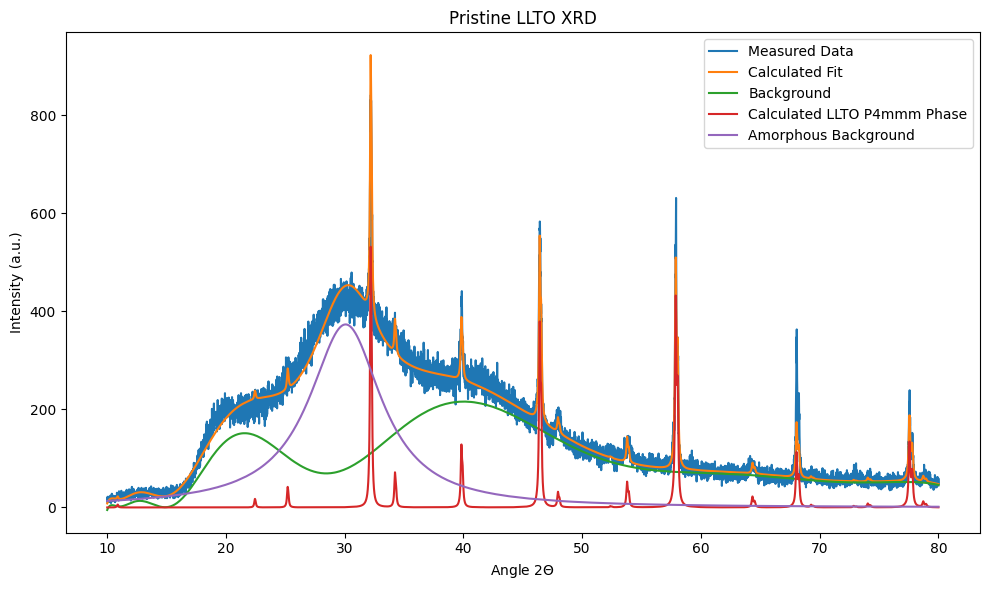

In [12]:
#Showing the data with the background

plt.figure(figsize=(10, 6))

#Manually add the column labels. The first column in the .dia file is the 2 Theta Diffraction Angle.
labels=['Measured Data','Calculated Fit', 'Background','Calculated LLTO P4mmm Phase','Amorphous Background']

#First Column is the 2 theta angle which gets plotted to the x-axis
x = df_fit.iloc[:, 0]
#Iterate over the other columns, manually labeling with the labels list.
for i in range(1, df_fit.shape[1]):
    plt.plot(x, df_fit.iloc[:, i], label=labels[i-1])

plt.xlabel("Angle 2$\Theta$")
plt.ylabel("Intensity (a.u.)")
plt.title("Pristine LLTO XRD")
plt.legend()
#plt.grid(True)
plt.tight_layout()
plt.savefig('LLTO_Pristine_XRD_Fit.png', dpi=900)
plt.show()

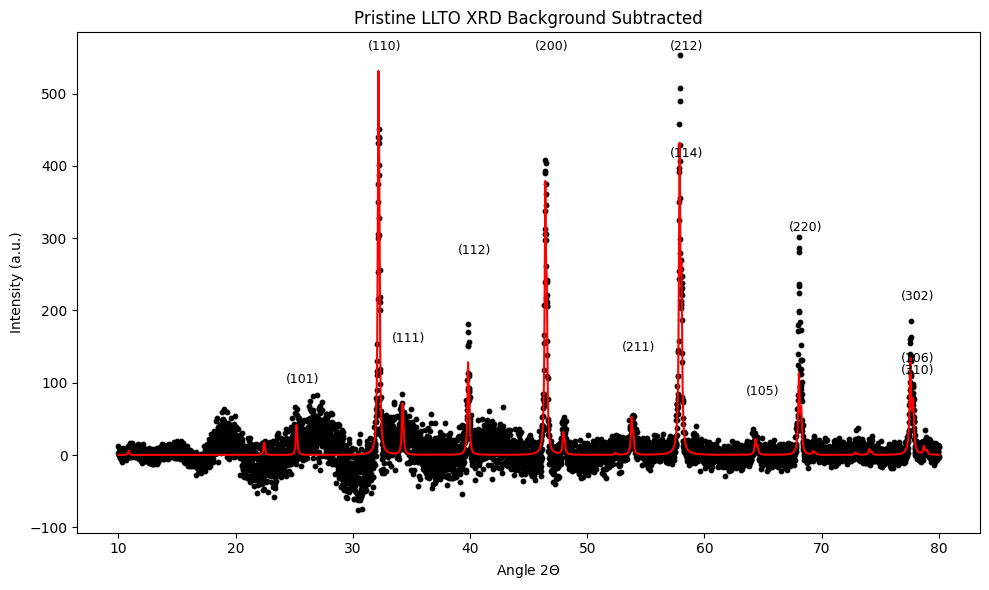

In [13]:
# Plot the background subtracted data with the hkl values labeled.
plt.figure(figsize=(10, 6))

#Background Subtraction
# We want to plot the background subtracted data and the calculated spectrum
BG_sub_data = df_fit.iloc[:, 1] - df_fit.iloc[:, 3] - df_fit.iloc[:, 5]
Calc = df_fit.iloc[:, 4]
# Diffraction angle 2 theta
x = df_fit.iloc[:, 0]

#This is where we will insert the hkl values - above the highest peak
y_top = Calc.max()

#And just a helper to find the max of the plot to prevent the hkl from being off the plot.
Plot_max = max(Calc.max(),BG_sub_data.max())

#Iterate over the other columns, manually labeling with the labels list.
plt.scatter(x, BG_sub_data,label='Background Subtracted Measured Spectrum',s=10,c='k')
plt.plot(x,Calc,label='Calculated LLTO P4mmm Phase',color='red')

#Define the max relative intensity to scale locations of hkl labels
Max_RelI= max(peak_df['Rel. intensity (%)'])

for _, row in peak_df.iterrows():
    angle = row["Angle (°2θ)"]
    hkl_label = row["hkl"]
    Rel_Int = row["Rel. intensity (%)"]

    if float(Rel_Int) > hkl_Cutoff:
      plt.annotate(hkl_label, xy=(float(angle), min(Plot_max*.96,float(Rel_Int)/float(Max_RelI)*y_top*1.8)),
                  xytext=(0, 15), textcoords='offset points',
                  ha='center', fontsize=9)
    else:
      continue

plt.xlabel("Angle 2$\Theta$")
plt.ylabel("Intensity (a.u.)")
plt.title("Pristine LLTO XRD Background Subtracted")
#plt.legend()
#plt.grid(True)
plt.tight_layout()
plt.savefig('LLTO_BGSub_hkl.png', dpi=900)
plt.show()